# Imports and some useful functions

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import pymc as pm
import aesara
import aesara.tensor as at
import arviz as az

from modelling_functions import (
    normalize, 
    masked_mean,
    get_data
)

import yoon_model_functions_pooled
import yoon_model_functions_hierarchical
import my_model_functions

# Get and plot Yoon's data

In [4]:
dt, utt_i, goal_id, goals, dt_meaning = get_data()

## Basic plotting

In [10]:
dt_social = dt[dt['goal'] == 'social']
dt_social = dt_social.drop(columns=['goal', 'item'])
dt_social = dt_social.reset_index(drop=True)

In [11]:
dt

trial          item         goal  true_state positivity utterance   id  \
0         1          song  informative           3     no_neg   amazing    0   
1         2      painting  informative           2     no_neg      good    0   
2         3          cake  informative           0     no_neg  terrible    0   
3         4          film  informative           1     no_neg       bad    0   
4         5       recital       social           3     no_neg   amazing    0   
...     ...           ...          ...         ...        ...       ...  ...   
2431      8       recital         both           1        neg  terrible  202   
2432      9        cookie       social           3     no_neg   amazing  202   
2433     10  presentation       social           0        neg       bad  202   
2434     11           app       social           2        neg       bad  202   
2435     12          song       social           1        neg  terrible  202   

     utterance_full  utterance_index  
0           amazing                3  
1              good                2  
2          terrible                0  
3               bad                1  
4           amazing                3  
...             ...              ...  
2431   not terrible                4  
2432        amazing                3  
2433        not bad                5  
2434        not bad                5  
2435   not terrible                4  

[2436 rows x 9 columns]

Each participant is asked to be kind in 4 trials

<AxesSubplot:>

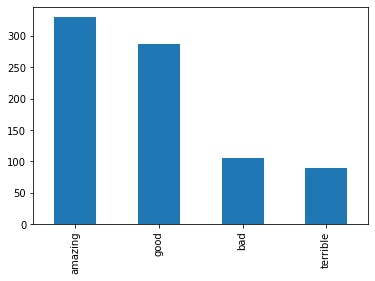

In [10]:
%matplotlib inline
dt_social['utterance'].value_counts().plot.bar()

In [11]:
df_plotting_kind = (
    dt_social
    .groupby(['positivity', 'true_state'])
    ['utterance']
    .value_counts()
    .fillna(0)
    .to_frame()
    .rename(columns={'utterance': 'count'})
    .unstack().fillna(0)
    .stack()
    .reset_index()
) 

In [19]:
df_plotting_kind.groupby('true_state').sum()

count
true_state       
0           203.0
1           203.0
2           203.0
3           203.0

In [20]:
df_plotting_kind.loc[:, 'count'] = df_plotting_kind['count'] / 203

[]

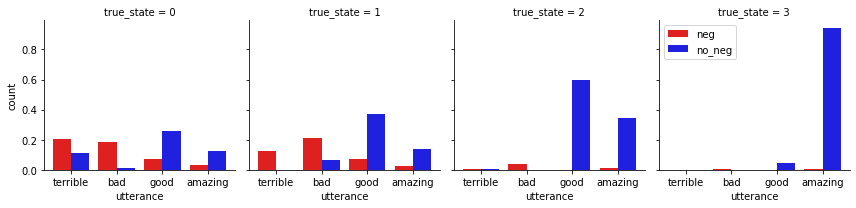

In [21]:
g = sns.FacetGrid(
    data=df_plotting_kind,
    col='true_state',
)

g.map_dataframe(
    sns.barplot,
    x='utterance',
    y='count',
    hue='positivity',
    order=['terrible', 'bad', 'good', 'amazing'],
    palette={'neg':'r', 'no_neg':'b'},
)

# map(lambda ax: ax.set_xticks(np.arange(4), labels=['terrible', 'bad', 'good', 'amazing']), g.axes)

plt.legend()
plt.plot()

Find the correlations in the data: are participants that produce one signal for 0 hearts more likely to produce another one for 1 heart?

In [22]:
df_transitions = (
    dt
    .loc[dt['true_state']<=1]
    .groupby(['goal', 'id'])
    ['utterance_full']
    .transform(lambda x: ' -> '.join(x))
    .iloc[::2]
    .reset_index(drop=True)
    .to_frame()
)

df_transitions.loc[:,'goal'] = (
    dt
    .loc[dt['true_state']<=1,'goal']
    .iloc[::2]
    .reset_index(drop=True)
)

df_transitions.loc[:,'id'] = (
    dt
    .loc[dt['true_state']<=1,'id']
    .iloc[::2]
    .reset_index(drop=True)
)

df_transitions = (
    df_transitions
    .groupby(['goal','utterance_full'])
    .count()
    .reset_index()
    .rename(columns={'id':'counts'})
    .sort_values('counts')
)

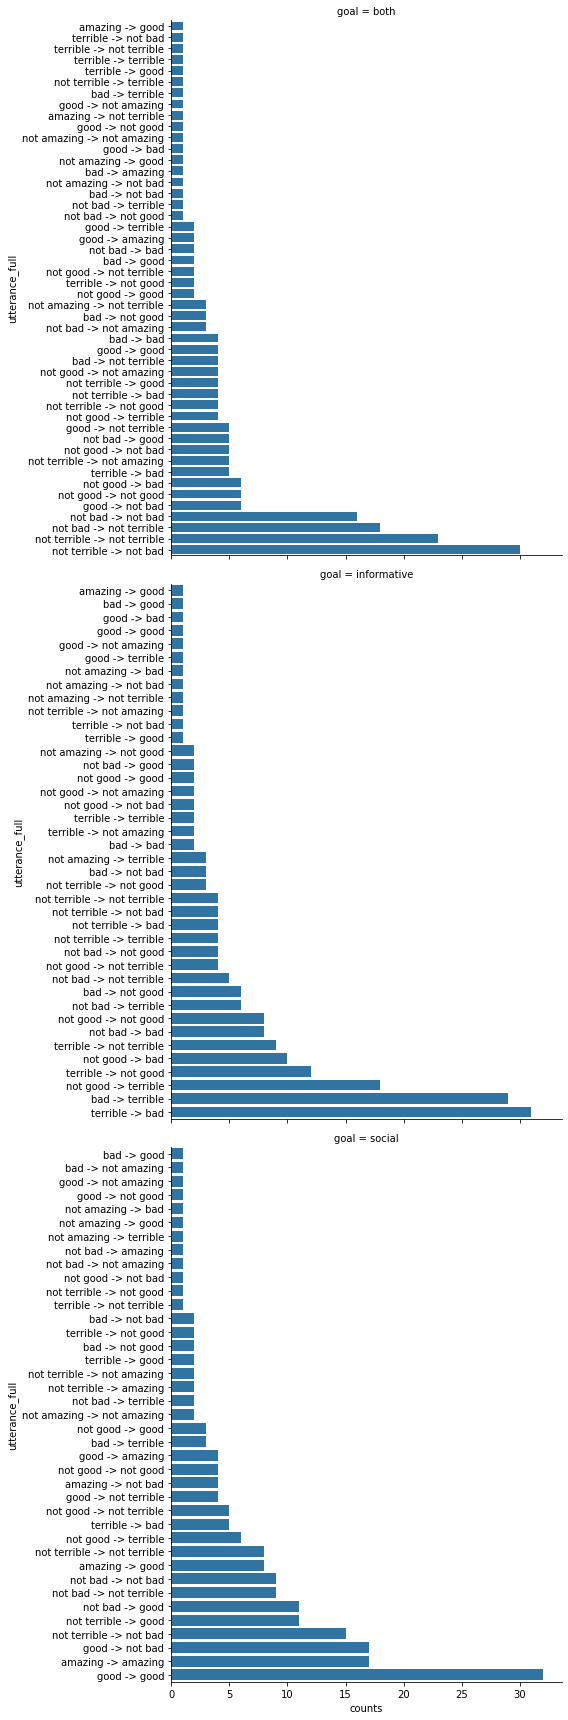

In [595]:
%matplotlib inline

g = sns.FacetGrid(
    data=df_transitions,
    row='goal',
    height=8,
    aspect=1,
    sharey=False
)

g.map_dataframe(
    sns.barplot,
    y='utterance_full',
    x='counts',
    orient='h'
)

# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(rotation=90)
    
g.savefig('transition_counts.png', dpi=300)

In [59]:
def f(df):
    df = df.sort_values('true_state')
    df_ = pd.Series(
        df.utterance_full.ravel(),
        index=df.true_state.ravel()
    )
    return df_

In [162]:
choices_series = (
    dt
    .groupby(['id', 'goal'])
    .apply(f)
    .reset_index()
)

choices_series.loc[:,0:] = choices_series.loc[:,0:].apply(
    lambda x: x.str.pad(width=12, side='right', fillchar=' ')
)

choices_concatenated = (
    choices_series[0]
    .str
    .cat(choices_series.loc[:,1:], sep=' > ')
    .to_frame(name='choices')
    .assign(goal=choices_series.goal)
    .value_counts()
    .to_frame('counts')
    .reset_index()
)

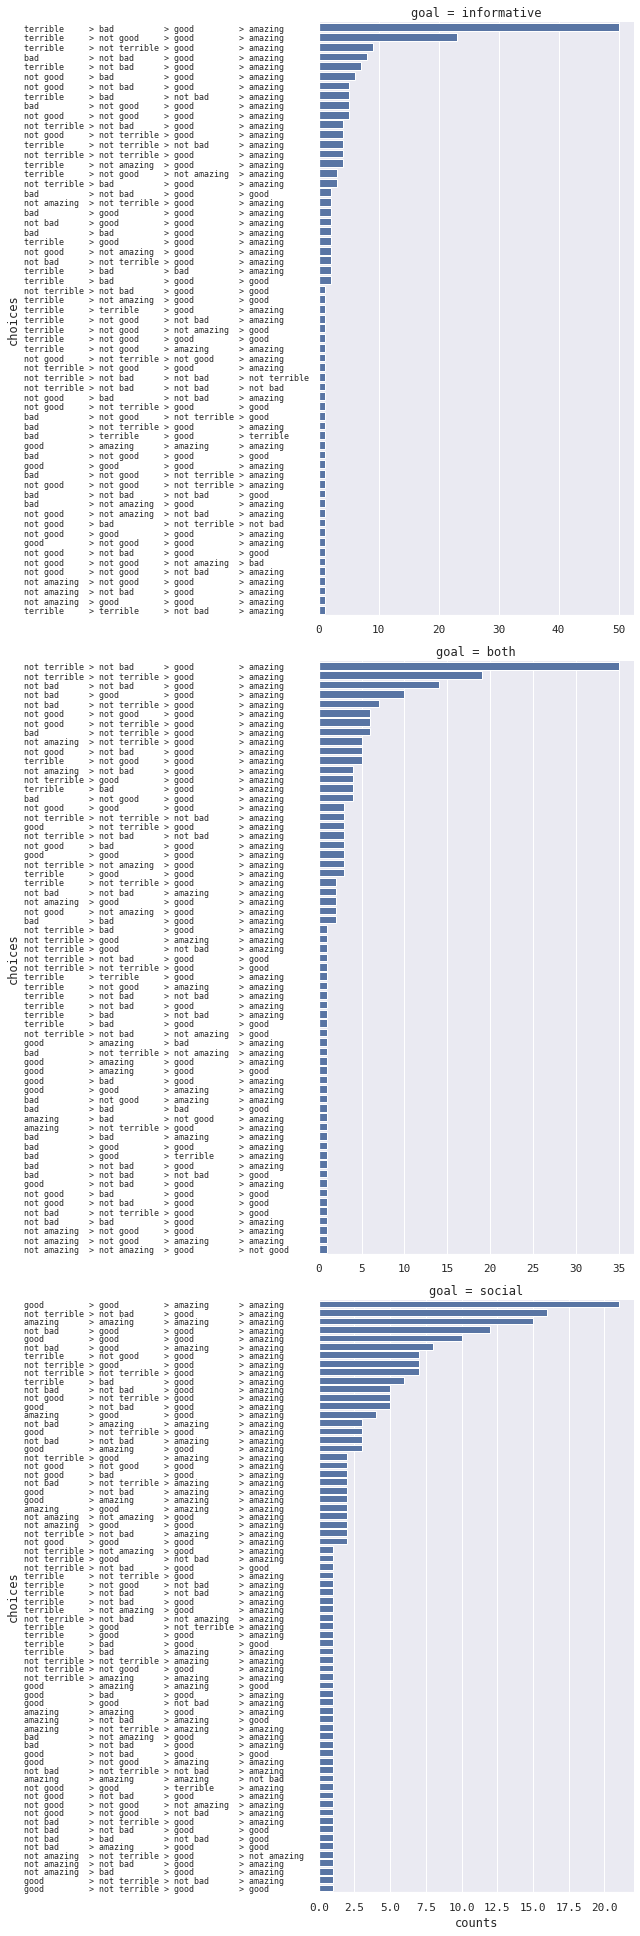

In [179]:
%matplotlib inline
with sns.plotting_context(rc={'font':'monospace', 'ytick.labelsize': 'small'}):
    
    g = sns.FacetGrid(
        data=choices_concatenated,
        row='goal',
        sharex=False,
        sharey=False,
        height=9,
        aspect=1,
    )

    g.map_dataframe(
        sns.barplot,
        y='choices',
        x='counts',
        orient='h'
    )

## Sankey plots

In [180]:
from pySankey import sankey

In [182]:
choices_series

id         goal             0             1             2             3
0      0         both  not terrible  not bad       good          amazing     
1      0  informative  terrible      bad           good          amazing     
2      0       social  not bad       good          amazing       amazing     
3      1         both  not bad       good          good          amazing     
4      1  informative  bad           not bad       good          amazing     
..   ...          ...           ...           ...           ...           ...
604  201  informative  terrible      bad           good          amazing     
605  201       social  terrible      bad           good          amazing     
606  202         both  not amazing   not terrible  good          amazing     
607  202  informative  not good      not good      good          amazing     
608  202       social  not bad       not terrible  not bad       amazing     

[609 rows x 6 columns]

Empty DataFrame
Columns: []
Index: []

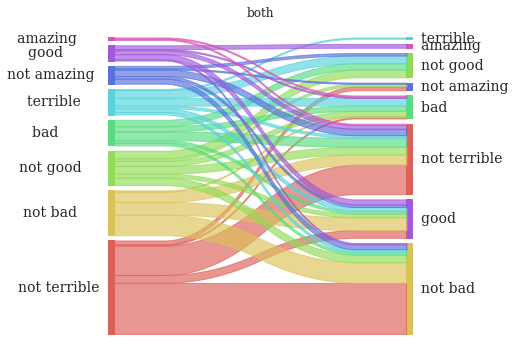

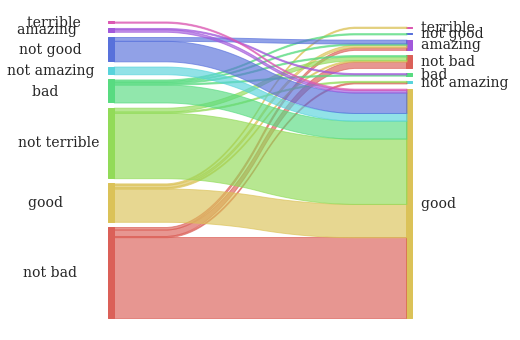

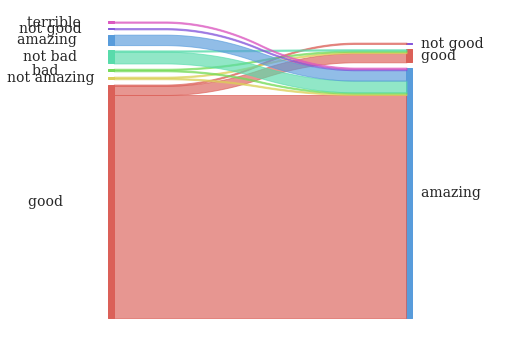

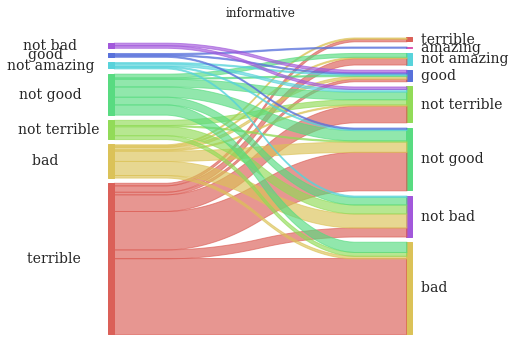

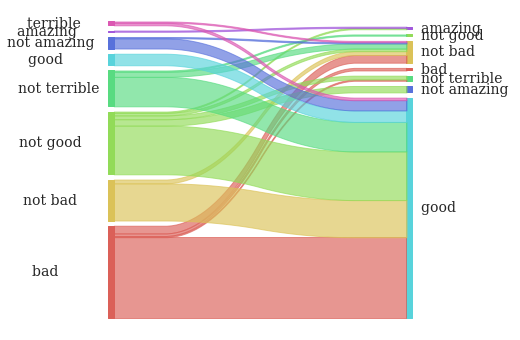

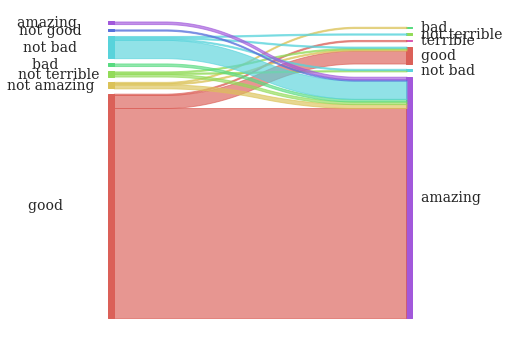

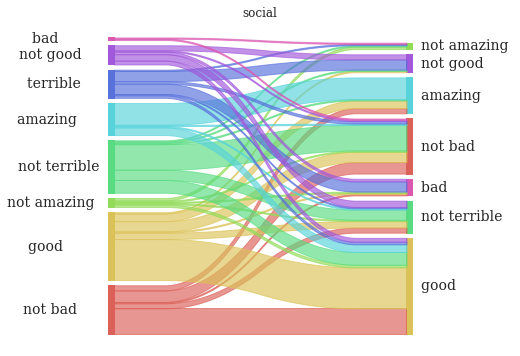

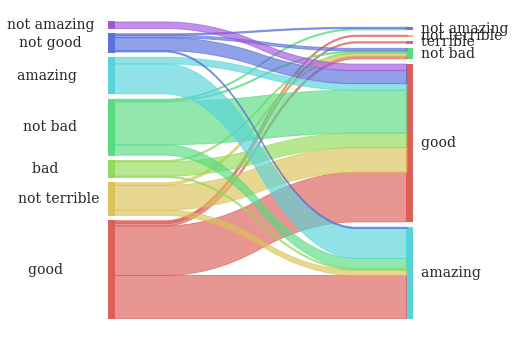

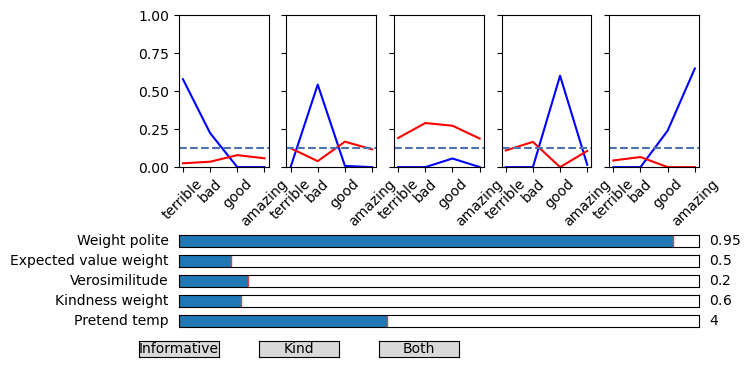

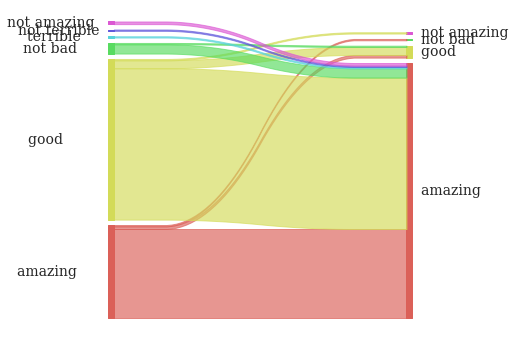

In [210]:
def g_f(data, **kws):
        
    plt.sca(axes[0])
    sankey.sankey(
        data.loc[:,0],
        data.loc[:,1],
    )
    plt.title(data['goal'].iloc[0])
    
    plt.sca(axes[1])
    sankey.sankey(
        data.loc[:,1],
        data.loc[:,2],
    )
    
    plt.sca(axes[2])
    sankey.sankey(
        data.loc[:,2],
        data.loc[:,3],
    )
    

(
    choices_series
    .groupby('goal')
    .apply(g_f)
)

# Yoon's model in numpy

## Description

Possible instructions:
- Be informative: "give accurate and informative feedback"
- Be kind: "make the listener feel good"
- Both

From the supplementary material to the Yoon paper (equation 4 has a typo: it should also condition on $\phi$):

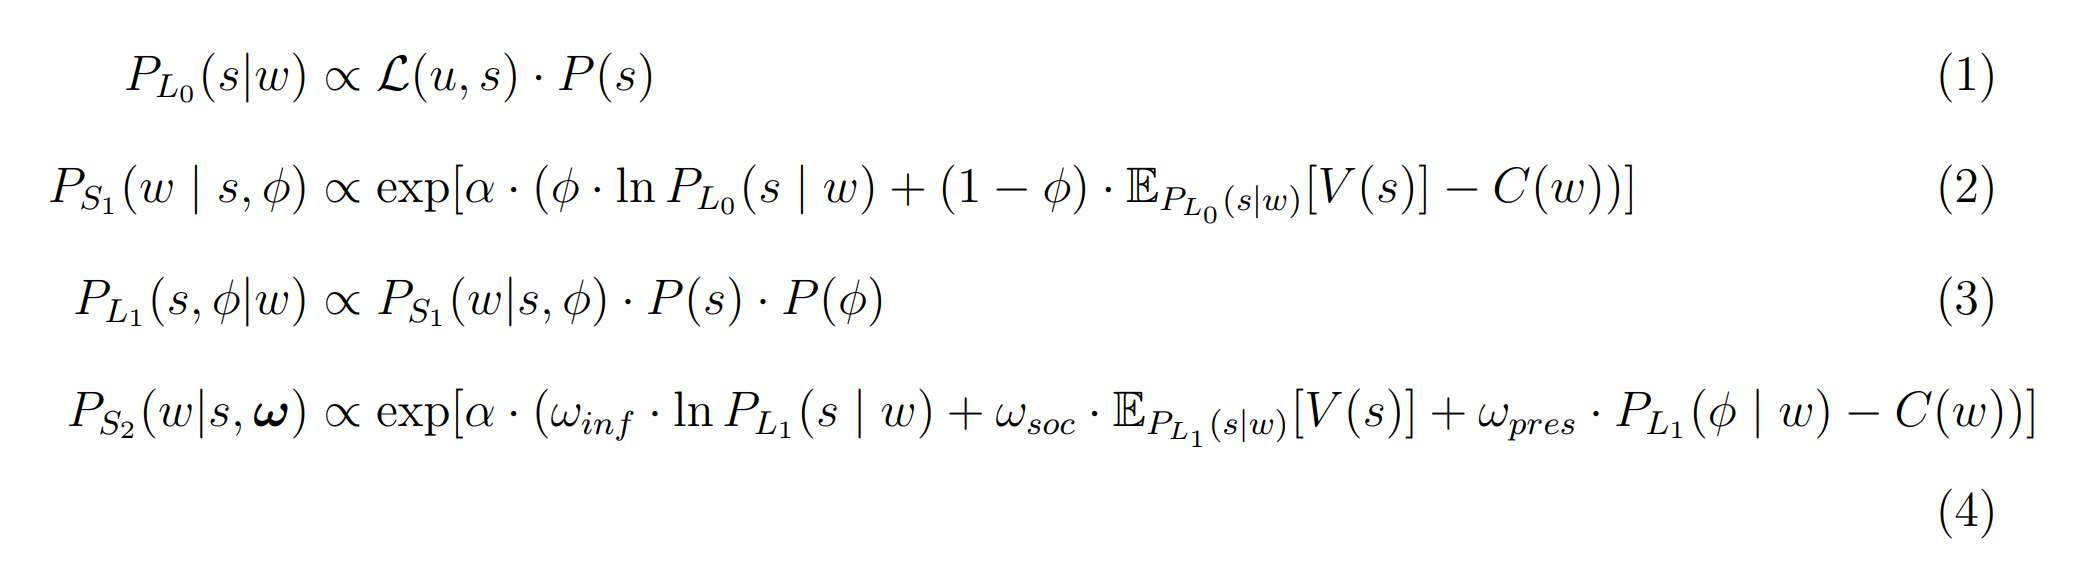

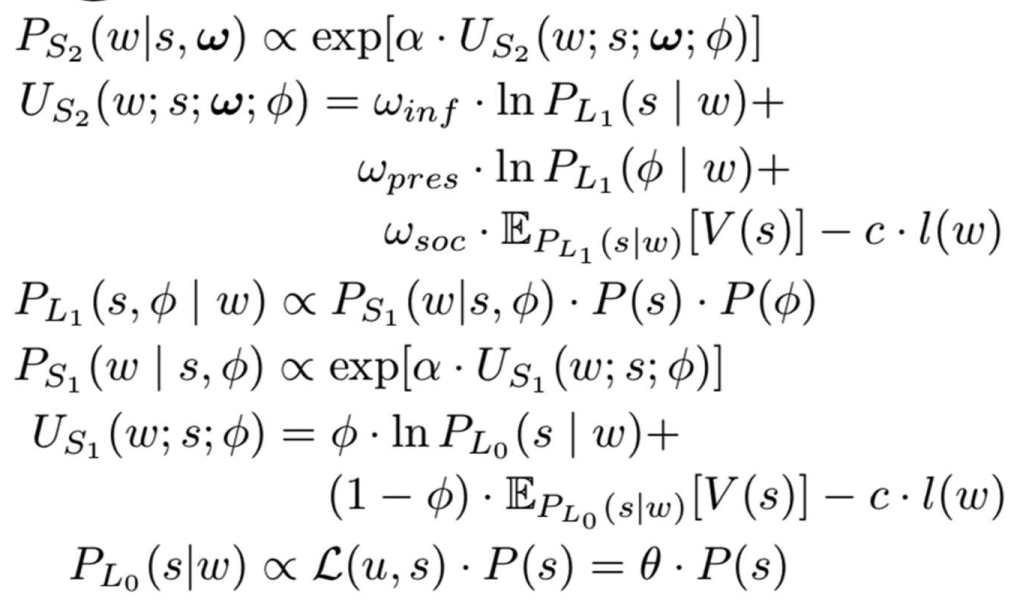

Suppose we wanted to calculate $S_2$ explicitly. Then we'd have to calculate:

\begin{align}
P_{L_1} (s \mid w) 
&= \int_0^1 P_{L_1} (s, \phi \mid w) d\phi \\
&= \frac{1}{P_{S_1} (w)} \int_0^1 P_{S_1} (w \mid s, \phi) d\phi  
\end{align}

So we need to integrate this wrt $\phi$:

$$
P_{S_1} (w \mid s, \phi) = 
\frac{1}{P_{S_1} (s, \phi)}
\exp \left( 
    \alpha \phi \ln P_{L_0} (s \mid w)
    + \alpha (1-\phi) \mathbb{E}[V(s)]
    - \alpha C(w)
\right)
$$

The second part alone would be easy to integrate:

$$
e^{
\alpha \phi \ln P_{L_0} (s \mid w)
+ \alpha \mathbb{E}[V(s)]
- \alpha \phi \mathbb{E}[V(s)]
- \alpha C(w)
}
$$

$$
e^{
\phi \alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
+ \alpha \mathbb{E}[V(s)]
- \alpha C(w)
}
$$

$$
e^{ 
\phi \alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
e^{
\alpha \mathbb{E}[V(s)]
}
e^{
\alpha C(w)
}
$$

Using:

$$
\int_0^1 e^{a \phi} d\phi = \dfrac{\mathrm{e}^a}{a}-\dfrac{1}{a}
$$

As the following integral:

$$
e^{
\alpha \mathbb{E}[V(s)]
}
e^{
\alpha C(w)
}
\int_0^1
e^{ 
\phi \alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
d\phi
= \\
e^{
\alpha \mathbb{E}[V(s)]
}
e^{
\alpha C(w)
}
\left(
\dfrac{
\mathrm{e}^{
\alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
}{
\alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}-\dfrac{1}{
\alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
\right)
$$

But unfortunately the expressions to integrate also contains $\frac{1}{P_{S_1} (s, \phi)}$, where:

$$
P_{S_1} (s, \phi) 
= \sum_{w} P_{S_1} (w, s, \phi) 
= \sum_{w} 
e^{
\alpha \phi \ln P_{L_0} (s \mid w)
+ \alpha \mathbb{E}[V(s)]
- \alpha \phi \mathbb{E}[V(s)]
- \alpha C(w)
}
$$

So instead of integration I just do grid integration for the phi parameter. It seems to give results that are pretty close to the ones in the paper.

## Implementation

In [87]:
# using a grid approximation
# for phi
phis = np.linspace(0,1,100)

us = [
    'terrible',
    'bad',
    'good',
    'amazing',
    'not terrible',
    'not bad',
    'not good',
    'not amazing'
]

# costs taken from https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
costs = np.array([
    1,
    1,
    1,
    1,
    2,
    2,
    2,
    2
])

# literal semantic compatibility
# shape: (utterances, states)
# Copied from 
# https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
L = np.array([
    [0.961, 0.627, 0.039, 0.039],
    [0.980, 0.882, 0.039, 0.020],
    [0.001, 0.020, 0.941, 0.999],
    [0.001, 0.001, 0.216, 0.980],
    [0.001, 0.353, 0.980, 0.863],
    [0.020, 0.157, 0.999, 0.902],
    [0.961, 0.863, 0.039, 0.020],
    [0.961, 0.980, 0.627, 0.039]
])

# goal weights
# [informational, prosocial, presentational]
omega = normalize(
    np.array([1,1,1]),
    0
)

values = np.array([0, 1, 2, 3])

# https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
alpha = 2.5

In [379]:
L0 = normalize(L,1)

# expected value given each utterance
# NOTE: This only works if L is not
# exactly 0 anywhere!
exp_values = np.mean(
    values*L0,
    1
)

# p(u | s, phi)
# where phi is essentially 
# a politeness weight
S1 = normalize(
    np.exp(alpha*(
        # informational component
        + phis[:,None,None]*np.log(L0)
        # social component
        + (1-phis)[:,None,None]*exp_values[:,None]
        - costs[:,None]
    )),
    axis=(1)
)

# Prob of state and phi
# given utterance
L1 = normalize(
    S1,
    (0,2)
)

# informativity of utterances given state
# with utterances produced by L1
u_inf = np.log(L1)

L1_s_given_w = L1.sum(0)

# expected value of state
# given utterance as produced by L1
u_soc = np.mean(
    values*L1_s_given_w,
    1
)

# marginalize across states
u_pres = S1.sum(2)

# shape (3, value of phi, utterance, state)
utilities = np.stack(np.broadcast_arrays(
    u_inf,
    u_soc[None,:,None],
    u_pres[:,:,None]
))

util_total = (
    (
        omega[:,None,None,None] 
        # The normalization is not in the paper
        # But it is in the code!
        # in https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
        * normalize(utilities,0)
    )
    .sum(0) 
    - costs[:,None]
)

# prob of utterance given state
# Shape: (phi, utterance, state)
S2 = normalize(
    np.exp(alpha*util_total), 
    1
)

In [325]:
S1.shape

(100, 8, 4)

In [318]:
S1.sum(1)[:10]

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [130]:
S2.shape

(100, 8, 4)

## Reproduce Figure 2

In [320]:
%matplotlib inline

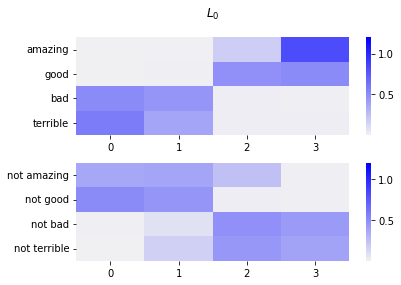

In [380]:
L0_df = pd.DataFrame(
    L0,
    index=us
)

fig, (ax1, ax2) = plt.subplots(2,1)

cmap = sns.color_palette("light:b", as_cmap=True)

# cmap.reversed()

sns.heatmap(
    L0_df.iloc[3::-1],
    ax=ax1,
    cmap=cmap,
    vmax=1.2
)

sns.heatmap(
    L0_df[:3:-1],
    ax=ax2,
    cmap=cmap,
    vmax=1.2
)

fig.suptitle(r'$L_0$')
plt.tight_layout()
plt.show()

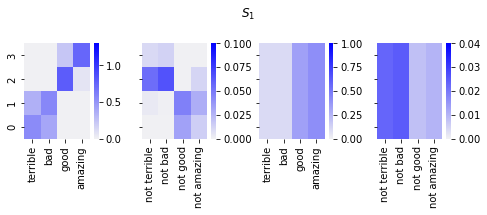

In [381]:
S1_df_info = pd.DataFrame(
    S1[-1].T,
    columns=us
)

S1_df_social = pd.DataFrame(
    S1[0].T,
    columns=us
)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1,4, 
    figsize=(7,3),
    sharey=True
)

cmap = sns.color_palette("light:b", as_cmap=True)

# cmap.reversed()

sns.heatmap(
    S1_df_info.iloc[::-1,:4],
    ax=ax1,
    cmap=cmap,
    vmin=0,
    vmax=1.3
)

sns.heatmap(
    S1_df_info.iloc[::-1,4:],
    ax=ax2,
    cmap=cmap,
    vmin=0,
    vmax=0.1
)

sns.heatmap(
    S1_df_social.iloc[::-1,:4],
    ax=ax3,
    cmap=cmap,
    vmin=0,
    vmax=1
)

sns.heatmap(
    S1_df_social.iloc[::-1,4:],
    ax=ax4,
    cmap=cmap,
    vmin=0,
    vmax=0.04
)

fig.suptitle(r'$S_1$')

plt.tight_layout()
plt.show()

In [397]:
# bin the phi parameter into 5 bins
# and take means, to get clsoe to the figure
L1_toplot = np.stack(np.split(L1, 5)).mean(1).swapaxes(0,1)

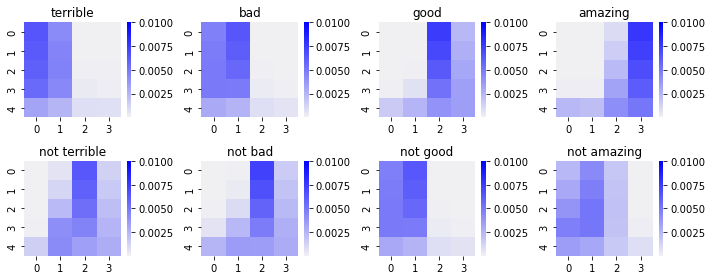

In [412]:
fig, axes = plt.subplots(2,4, figsize=(10,4))
cmap = sns.color_palette("light:b", as_cmap=True)

for i, (ax, subdf, u) in enumerate(zip(axes.flatten(), L1_toplot, us)):
    sns.heatmap(
        subdf[::-1], 
        cmap=cmap,
        ax=ax,
        vmax=0.01
    )
    ax.set_title(u)
    
plt.tight_layout()

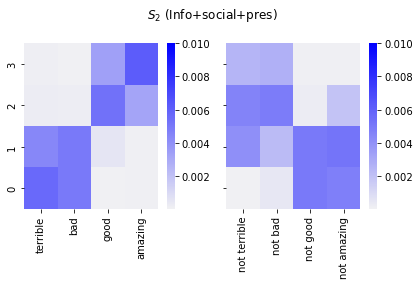

In [386]:
uinf_df = pd.DataFrame(
    # value is exponentiated in plotted figure
    # not sure why!
    np.exp(u_inf)[30],
    index=us
).T

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

cmap = sns.color_palette("light:b", as_cmap=True)

# cmap.reversed()

sns.heatmap(
    uinf_df.iloc[::-1,:4],
    ax=ax1,
    cmap=cmap,
    vmax=0.01
)

sns.heatmap(
    uinf_df.iloc[::-1,4:],
    ax=ax2,
    cmap=cmap,
    vmax=0.01
)

fig.suptitle(r'$S_2$ (Info+social+pres)')

plt.tight_layout()
plt.show()

# Fit Yoon's model to data

## Non-hierarchical

In [ ]:
yoon_model = yoon_model_functions.factory_yoon_model(
    dt,
    dt_meaning
)

In [ ]:
yoon_trace = az.from_netcdf(
    'traces/yoon_trace_nonhierarchical.cdf'
)

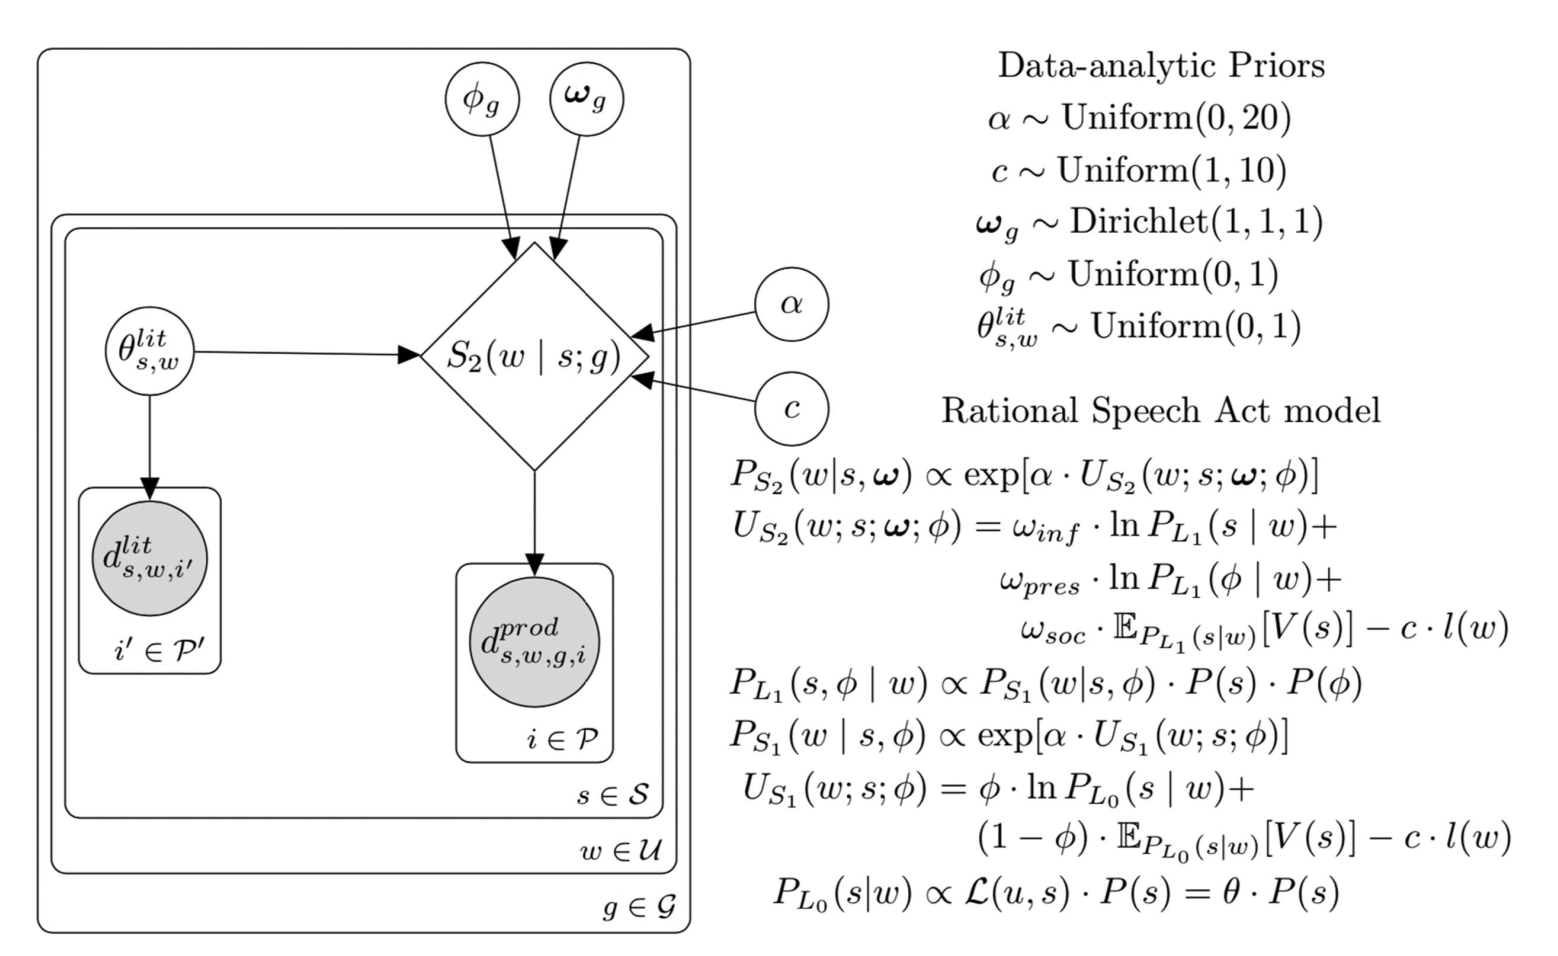

### Reproduce figure 2 with the functions

Plot $S_1$ from Figure 2:

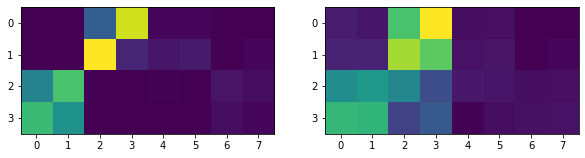

In [216]:
x = yoon_model_functions.yoon_S1(
    # values
    np.array([0, 1, 2, 3]), 
    # alpha
    2.6, 
    np.array([
        1,1,1,1,2,2,2,2
    ])
)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.imshow(np.flipud(x[-5].T))
ax1.imshow(np.flipud(x[5].T))

Plot $L_1$ from Figure 2:

In [217]:
# Dimensions (phi, utterance, state)
L1_s_phi_given_w_grid = normalize(
    x,
    (0,2)
)

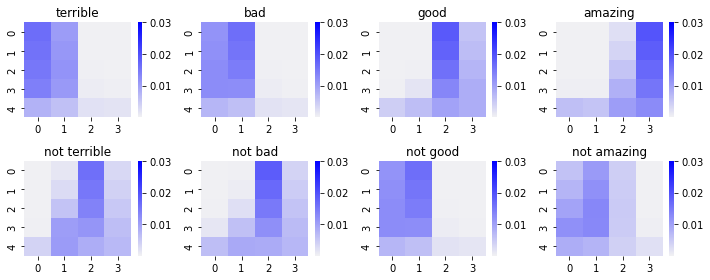

In [218]:
# bin the phi parameter into 5 bins
# and take means, to get clsoe to the figure
L1_toplot = np.stack(np.split(L1_s_phi_given_w_grid, 5)).mean(1).swapaxes(0,1)

fig, axes = plt.subplots(2,4, figsize=(10,4))
cmap = sns.color_palette("light:b", as_cmap=True)

for i, (ax, subdf, u) in enumerate(zip(axes.flatten(), L1_toplot, us)):
    sns.heatmap(
        subdf[::-1], 
        cmap=cmap,
        ax=ax,
        vmax=0.03
    )
    ax.set_title(u)
    
plt.tight_layout()

In [221]:
values =  np.array([0, 1, 2, 3])
costs = aesara.shared(np.array([
    1,1,1,1,2,2,2,2
]))

alpha =  at.dscalar('alpha')
omega =  at.dmatrix('omega')
phi =  at.ivector('phi')

In [222]:
output = yoon_model_functions.yoon_likelihood(
    alpha, 
    values, 
    omega, 
    costs, 
    phi, 
    phi_grid_n=40
)

f_S2 = aesara.function(
    [alpha, omega, phi], 
    outputs=output
)

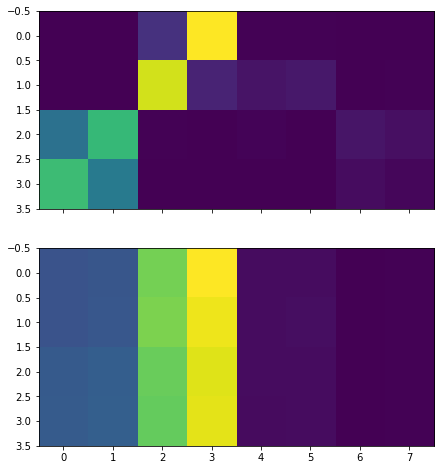

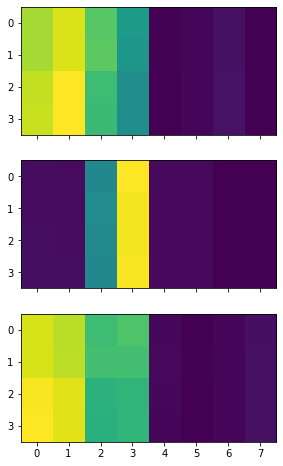

In [253]:
S2_inf, S2_soc, S2_both1, S2_both2, S2_both3 = f_S2(
    2.5, 
    # Weights (columns): inf, soc, pres
    [
        # informational
        [0.98, 0.01, 0.01], 
        # social
        [0.01, 0.98, 0.01],
        # presentational
        [0.01, 0.01, 0.98],
        # presentational
        [0.01, 0.01, 0.98],
        # presentational
        [0.01, 0.01, 0.98]
    ],
    # NOTE: The value of phi only matters for the 
    # presentational component of the utility
    [20, 20, 39, 0, 14]
)


fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,8))
ax1.imshow(np.flipud(S2_inf.T))
ax2.imshow(np.flipud(S2_soc.T))
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))
ax1.imshow(np.flipud(S2_both1.T))
ax2.imshow(np.flipud(S2_both2.T))
ax3.imshow(np.flipud(S2_both3.T))

### Trace plots

In [162]:
with az.rc_context(rc={'plot.max_subplots':100}):
    az.plot_pair(
        yoon_trace,
        var_names=['phi','alpha','omega']
    )
plt.savefig('posterior_correlations_yoon.png', dpi=300)
plt.close()

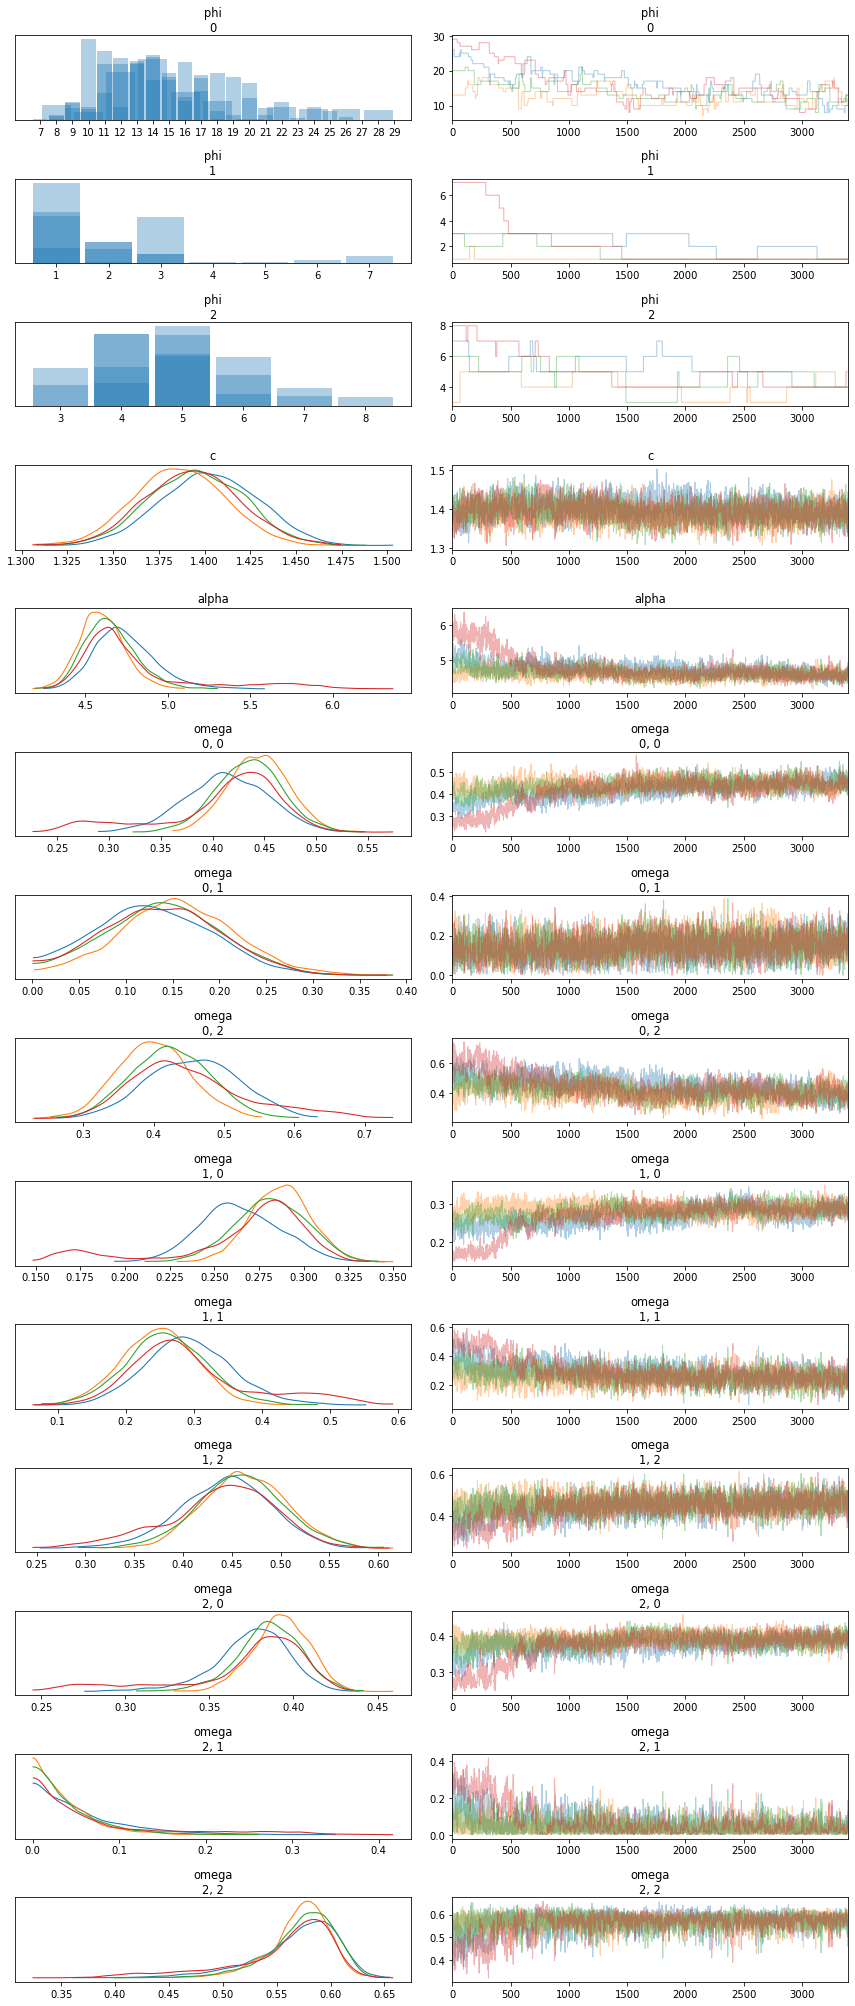

In [156]:
az.plot_trace(
    yoon_trace,
    compact=False,
    var_names="~L"
)
plt.tight_layout()
plt.show()

### Prior predictive checks

In [57]:
with yoon_model:
    yoon_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, c, chosen, omega, phi]


### Posterior predictive checks

In [157]:
with yoon_model:
    yoon_posterior_predictive = pm.sample_posterior_predictive(yoon_trace)

Sampling: [L_observed, chosen]


In [158]:
pps_yoon = yoon_posterior_predictive.posterior_predictive.chosen.values.reshape(-1,2436)

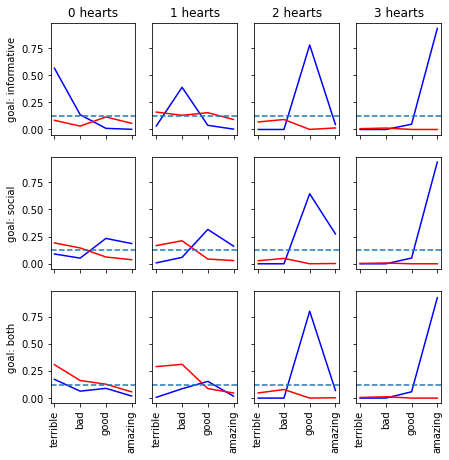

In [188]:
fig, axes = plt.subplots(
    3,4, 
    sharex=True, 
    sharey=True,
    figsize=(7,7)
)

for state in range(4):
    for goal in range(3):
        
        ax = axes[goal, state]
        
        # find proportion of each produced utterance
        # for that combination of goal and state
        subdt = (
            dt
            [(dt.true_state==state) & (dt.goal_id==goal)]
            .utterance_index
            .to_frame()
        )
        
        # posterior samples
        posterior_samples = pps_yoon[:,subdt.index].flatten()
        
        indices_us, counts = np.unique(
            posterior_samples, 
            return_counts=True
        )
        
        props = normalize(counts, 0)
        
        if len(indices_us) == 8:
            ax.plot(
                props[:4],
                color='blue'
            )
            
            ax.plot(
                props[4:],
                color='red'
            )
        ax.axhline(
            y=1/8,
            ls='--'
        )
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(us[:4], rotation=90)

[ax.set_ylabel(f'goal: {goal}') for ax,goal in zip(axes[:,0], goals)]
[ax.set_title(f'{i} hearts') for i, ax in enumerate(axes[0,:])]

# plt.show()
fig.savefig('yoon_nonhierarchical_fit.png', dpi=300)

## Hierarchical

In [57]:
with yoon_model:
    yoon_prior_predictive = pm.sample_prior_predictive()

Sampling: [L, L_observed, alpha, alpha_mu, alpha_sigma, c, chosen, omega, omega_condition, omega_sigma, omega_zs, phi, phi_goal_means, phi_goal_stds, phi_participants_zs]


In [ ]:
yoon_trace = az.from_netcdf(
    'traces/yoon_trace_hierarchical.cdf'
)

### Trace plots

### Posterior predictive checks

In [ ]:
for i, subdt in dt.groupby('id'):
    print(i, end=' ')
    fig, axes = plt.subplots(
        3,
        4,
        sharex=True,
        sharey=True,
        figsize=(12,4)
    )
    
    for j, subsubdt in subdt.sort_values(['goal','true_state']).groupby('goal_id'):

        for datapoint, subsubsubdt in subsubdt.iterrows():
            state = subsubsubdt['true_state']

            unique, counts = np.unique(
                pps_yoon[:,datapoint], 
                return_counts=True
            )
            axes[j][state].bar(
                unique,
                normalize(counts,0)
            )
            axes[j][state].axvline(
                subsubsubdt['utterance_index'],
                color='red'
            )
        
    axes[0][0].set_xticks(np.arange(8))
    [
        ax.set_xticklabels(us, rotation=90) 
        for ax in axes[-1]
    ]
    [
        ax.set_ylabel(goal)
        for goal, ax in zip(goals,axes[:,0])
    ]
    
    plt.tight_layout()
    
    fig.savefig(
        f'participant_posteriorpred_yoon/{i}.png',
        dpi=300
    )
    plt.close()

# My model in numpy

## Plotting functions

In [4]:
def plot_agents(utts, L0, S1, L1, fig, axes, S2=None):

    ims1 = [
        ax.imshow(L0[i])
        for i, ax in enumerate(axes[0])
    ]

    axes[0,0].set_ylabel('L0')
    axes[0,0].set_yticks(np.arange(len(utts)))
    axes[0,0].set_yticklabels(utts)

    ims2 = [
        ax.imshow(S1[i])
        for i, ax in enumerate(axes[1])
    ]

    axes[1,0].set_ylabel('S1')
    axes[1,0].set_yticks(np.arange(len(utts)))
    axes[1,0].set_yticklabels(utts)

    ims3 = [
        ax.imshow(L1[i])
        for i, ax in enumerate(axes[2])
    ]

    axes[2,0].set_ylabel('L1')
    axes[2,0].set_yticks(np.arange(len(utts)))
    axes[2,0].set_yticklabels(utts)
    
    [
        ax.set_title(s) 
        for ax, s in 
        zip(axes[0], ['Disparaging', 'Informative', 'Laudatory'])
    ]
    
    if S2 is not None:
        
        ims4 = [
            ax.imshow(S2[i])
            for i, ax in enumerate(axes[2])
        ]

        axes[2,0].set_ylabel('S2')
        axes[2,0].set_yticks(np.arange(len(utts)))
        axes[2,0].set_yticklabels(utts)

        return ims1, ims2, ims3, ims4
    
    return ims1, ims2, ims3

In [5]:
def plot_s1(S1, axes=None):
    # %matplotlib inline

    if axes is None:
        fig, axes = plt.subplots(
            1,
            len(values), 
            sharey=True,
            figsize=(13,2)
        )

    plotslist = []
    # loop over states
    for i, ax in enumerate(axes):

        line = S1[:,i]
        tbga = line[:4]
        n_tbga = line[4:]
        plot1 = ax.plot(
            tbga,
            color='blue'
        )[0]
        plot2 = ax.plot(
            n_tbga,
            color='red'
        )[0]

        plotslist.append([plot1, plot2])
        
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(
            ['terrible', 'bad', 'good', 'amazing'],
            rotation=45
        )

        ax.axhline(
            y=1/8, 
            linestyle='--'
        )

        ax.set_ylim(0,1)
        
    return plotslist

## Implementation

Intuition with this model:
- If I see a bad state and I am trying to be polite, I can pretend to be in a different state. This choice is affected by
    1. How much I gain by pretending to be in the better state. E.g. 'terrible'->'bad' is a bigger gain than 'good'->'excellent'
    2. How implausible it is to pretend to be in that state
- These two considerations may vary between participants!
- Given a pretend-state (which can also be the true state), I then select a signal
    - The signal tends to maximize the expected social utility
- Therefore, in this model social utility plays double duty: in deciding whether to pretend to be in a different state than one is, and in selecting a signal given the pretend-state.

In [15]:
def calculate_s1(values, 
                 likestate_utterance_compatibility, 
                 s1_rationality, 
                 pretend_temp=1., 
                 kindness_weight=1., 
                 verosimilitude=0.7, 
                 expected_value_weight=0.5
                ):
    
    Xs, Zs = np.indices((5,5))
    costs = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    
    ##### Polite speaker
    
    # given each true state, probability that the speaker 
    # will pretend to be in each other state
    # to balance social value and verosimilitude
    p_pretend = normalize(
        np.exp( 
            pretend_temp *
            # given true state (row), value of pretending to be in another state (col)
            # For each true observation and utterance,
            # the value of pretending to be in each observation
            # given the social value and the acceptability for the judge
            (
                # Kindness!
                # Tend to pretend to be in a positive state
                kindness_weight*values
                # Verosimilitude!
                # tend to not depart from truth (judge)
                # (is punished for departures from truth)
                # Uses exponential decay
                - verosimilitude*(np.abs(Xs - Zs)**2)
            )
        ),
        1
    )
    
    # literal listener
    L0 = normalize(
        likestate_utterance_compatibility,
        1
    )

    # expected social value of each utterance
    # given literal listener interpretation
    # Shape (utterance, state)
    expected_social_value = masked_mean(
        # social value of each state
        values
        # probability of each value 
        # given each utterance,
        # for the literal listener
        * L0,
        likestate_utterance_compatibility
    )

    S1 = normalize(
        np.exp(s1_rationality*(
            # tends to be informative
            np.log(
                # likestate_utterance_compatibility
                L0
            )
            + expected_value_weight*expected_social_value
            - costs[:,None]
        )),
        0
    )

    # shape: true state, pretend state, signal
    # Contains the joint probability, for each true state,
    # of the participant pretending to be in each state
    # AND sending a certain signal in that pretend state
    y = p_pretend[:,:,None] * S1.T

    # sum over pretend states 
    # to get marginal probability
    # (across pretend states)
    # of signal given true state
    S1_polite = y.sum(1).T
    
    return S1_polite

In [5]:
us = [
    'terrible',
    'bad',
    'good',
    'amazing',
    'not terrible',
    'not bad',
    'not good',
    'not amazing'
]

likestate_utterance_compatibility = np.array([
    # terrible
    [1, 0, 0, 0, 0],
    # bad
    [1, 1, 0, 0, 0],
    # good
    [0, 0, 0, 1, 1],
    # excellent
    [0, 0, 0, 0, 1],
    # not terrible
    [0, 1, 1, 1, 1],
    # not bad
    [0, 0, 1, 1, 1],
    # not good
    [1, 1, 1, 0, 0],
    # not excellent
    [1, 1, 1, 1, 0]
])


/tmp/ipykernel_269/3363798432.py:64: RuntimeWarning: divide by zero encountered in log
  np.log(


[[<matplotlib.lines.Line2D at 0x7feb45568070>,

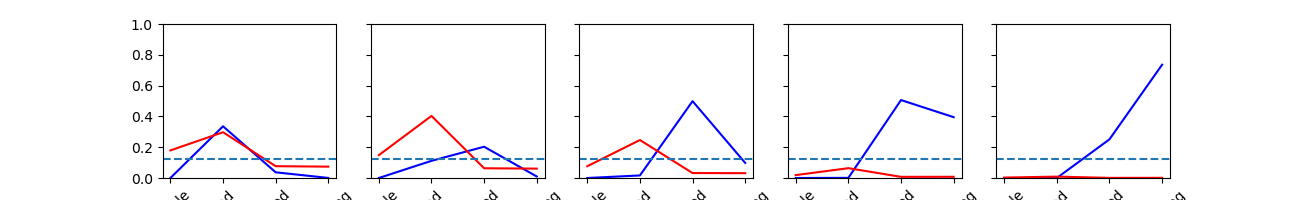

In [12]:
# assuming that the first dimension 
# is the true value 
values = np.array([-8., -2., 0., 1., 1.5])

s1_polite = calculate_s1(
    values, 
    likestate_utterance_compatibility, 
    s1_rationality=3, 
    pretend_temp=1., 
    kindness_weight=1., 
    verosimilitude=0.7, 
    expected_value_weight=0.5,
    # weight_polite=0.95
)

plot_s1(s1_polite)

## Plots

In [449]:
for i in range(100): plt.close()

/tmp/ipykernel_269/3916259777.py:61: RuntimeWarning: divide by zero encountered in log
  np.log(


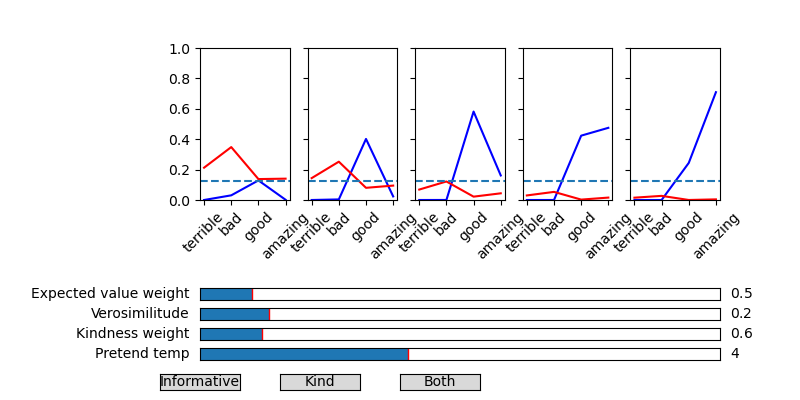

In [17]:
%matplotlib widget

##### Initial values

values = np.array([-8., -2., 0., 1., 1.5])

s1_rationality = 1.4
expected_value_weight = 0.5
verosimilitude = 0.2
kindness_weight = 0.6
pretend_temp = 4

s1_polite = calculate_s1(
    values, 
    likestate_utterance_compatibility, 
    s1_rationality=s1_rationality,
    pretend_temp=pretend_temp,
    kindness_weight=kindness_weight,
    verosimilitude=verosimilitude,
    expected_value_weight=expected_value_weight,
)

fig, axes = plt.subplots(
    1,
    len(values), 
    sharey=True,
    figsize=(8,4)
)

lines = plot_s1(s1_polite, axes)
    
# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.5)

# Make a horizontal slider 
ax1 = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider1 = Slider(
    ax=ax1,
    label='Pretend temp',
    valmin=0.,
    valmax=10,
    valinit=pretend_temp,
)

ax2 = fig.add_axes([0.25, 0.15, 0.65, 0.03])
slider2 = Slider(
    ax=ax2,
    label=r'Kindness weight',
    valmin=0.,
    valmax=5,
    valinit=kindness_weight,
)

ax3 = fig.add_axes([0.25, 0.2, 0.65, 0.03])
slider3 = Slider(
    ax=ax3,
    label=r'Verosimilitude',
    valmin=0.,
    valmax=1.5,
    valinit=verosimilitude,
)

ax4 = fig.add_axes([0.25, 0.25, 0.65, 0.03])
slider4 = Slider(
    ax=ax4,
    label=r'Expected value weight',
    valmin=0.,
    valmax=5,
    valinit=expected_value_weight,
)

def update_plot(s1_polite):
    
    # one tuple of lines for each 
    for i, (p1,p2) in enumerate(lines):
        
        # get the 5 lines for that signal
        line = s1_polite[:,i]
        
        tbga = line[:4]
        n_tbga = line[4:]

        p1.set_data(
            np.arange(4),
            tbga
        )
        p2.set_data(
            np.arange(4),
            n_tbga
        )
    
    img.autoscale()
    fig.canvas.draw_idle()
    

# The function to be called anytime a slider's value changes
def update(val):

    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=slider1.val,
        kindness_weight=slider2.val,
        verosimilitude=slider3.val,
        expected_value_weight=slider4.val,
    )
    
    update_plot(s1_polite)
    

# register the update function with each slider
slider1.on_changed(update)
slider2.on_changed(update)
slider3.on_changed(update)
slider4.on_changed(update)

# # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
# def reset(event):
#     slider1.reset()
#     slider2.reset()
#     slider3.reset()
#     slider4.reset()
#     slider5.reset()

# button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
# button = Button(button_ax, 'Reset', hovercolor='0.975')    
# button.on_clicked(reset)

def set_informative(event):
    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=6,
        kindness_weight=0.6,
        verosimilitude=0.2,
        expected_value_weight=0.5,
    )
    
    update_plot(s1_polite)

set_informative_ax = fig.add_axes([0.2, 0.025, 0.1, 0.04])
button_informative = Button(set_informative_ax, 'Informative', hovercolor='0.975')    
button_informative.on_clicked(set_informative)


def set_kind(event):
    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=1.6,
        kindness_weight=0.37,
        verosimilitude=0.02,
        expected_value_weight=2.8,
    )
    update_plot(s1_polite)

set_kind_ax = fig.add_axes([0.35, 0.025, 0.1, 0.04])
button_kind = Button(set_kind_ax, 'Kind', hovercolor='0.975')    
button_kind.on_clicked(set_kind)


def set_both(event):
    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=10,
        kindness_weight=0.1,
        verosimilitude=0.03,
        expected_value_weight=4,
    )
    update_plot(s1_polite)

set_both_ax = fig.add_axes([0.5, 0.025, 0.1, 0.04])
button_both = Button(set_both_ax, 'Both', hovercolor='0.975')    
button_both.on_clicked(set_both)

plt.show()

Params for informative condition:
- weight_polite = 0.1
- expected value weight = 0.5
- verosimilitude = 0.2
- kindness_weight = 0.6
- pretend_temp = 6

Params for kind condition:
- weight_polite = 0.82
- expected value weight = 2.8
- verosimilitude = 0.02
- kindness_weight = 0.37
- pretend_temp = 1.6
Although for top state, 'amazing' is produced less than data

Params for both condition:
- weight_polite = 0.7
- expected value weight = 4
- verosimilitude = 0.03
- kindness_weight = 0.1
- pretend_temp = 10

# Fit my model to data

In [15]:
model = my_model_functions.my_model_factory(dt)

In [64]:
trace.from_netcdf("trace_mymodel.cdf")

'trace_variable_values.cdf'

In [19]:
with model:
    var_fit = pm.fit()

Finished [100%]: Average Loss = 3,842.7


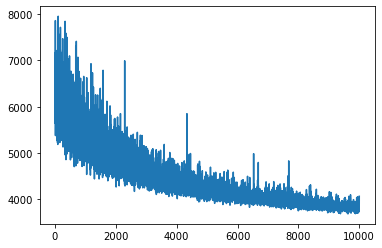

In [22]:
plt.plot(var_fit.hist)

## Trace plots

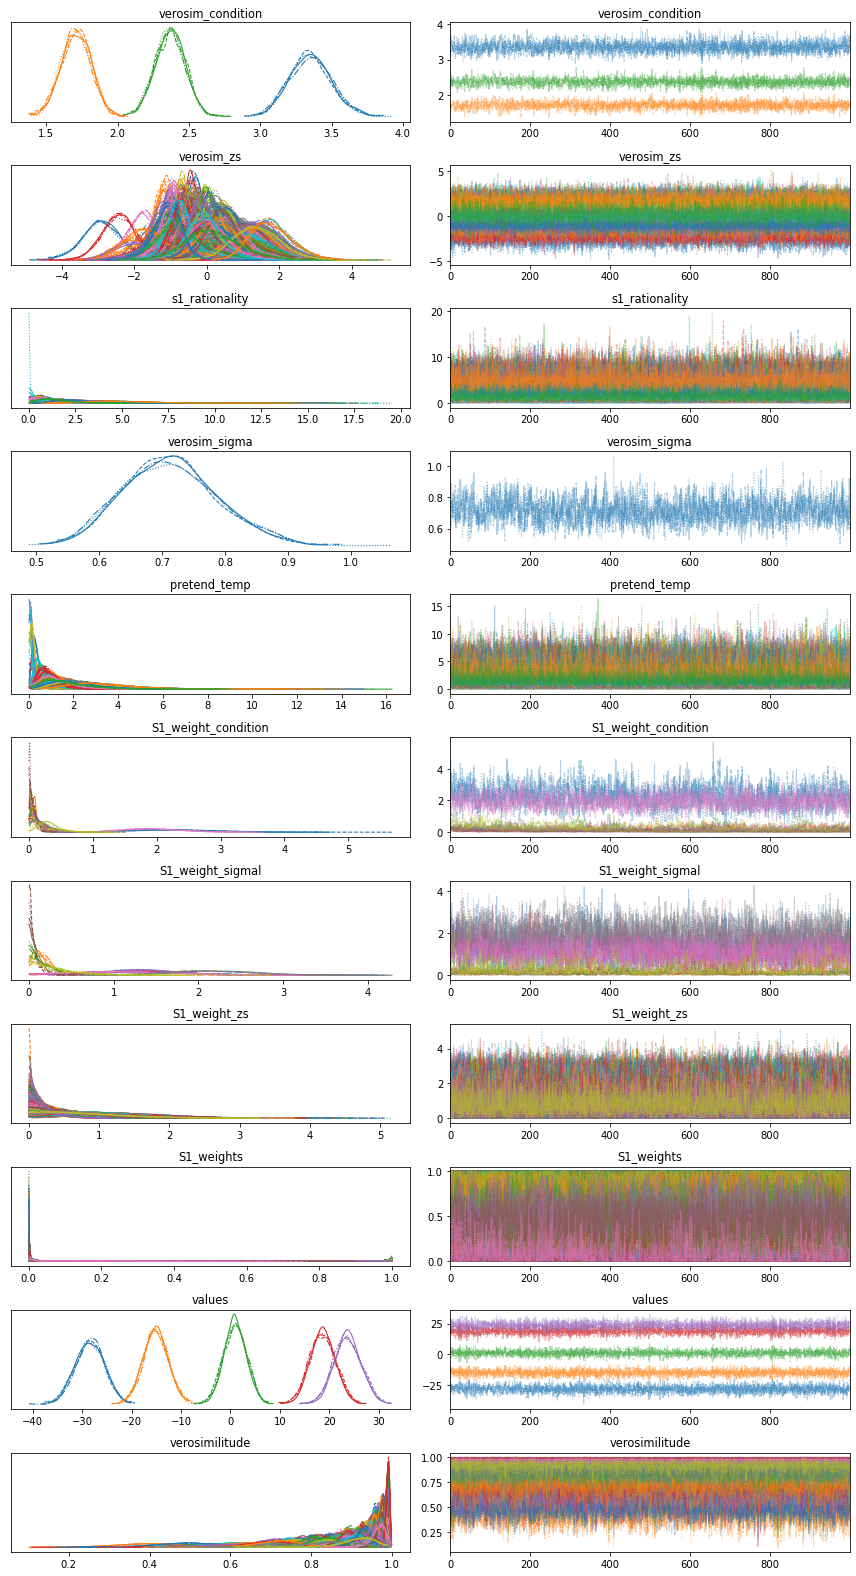

In [65]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

/home/fausto/anaconda3/envs/argumentative_language/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (609), generating only 20 plots
  warnings.warn(


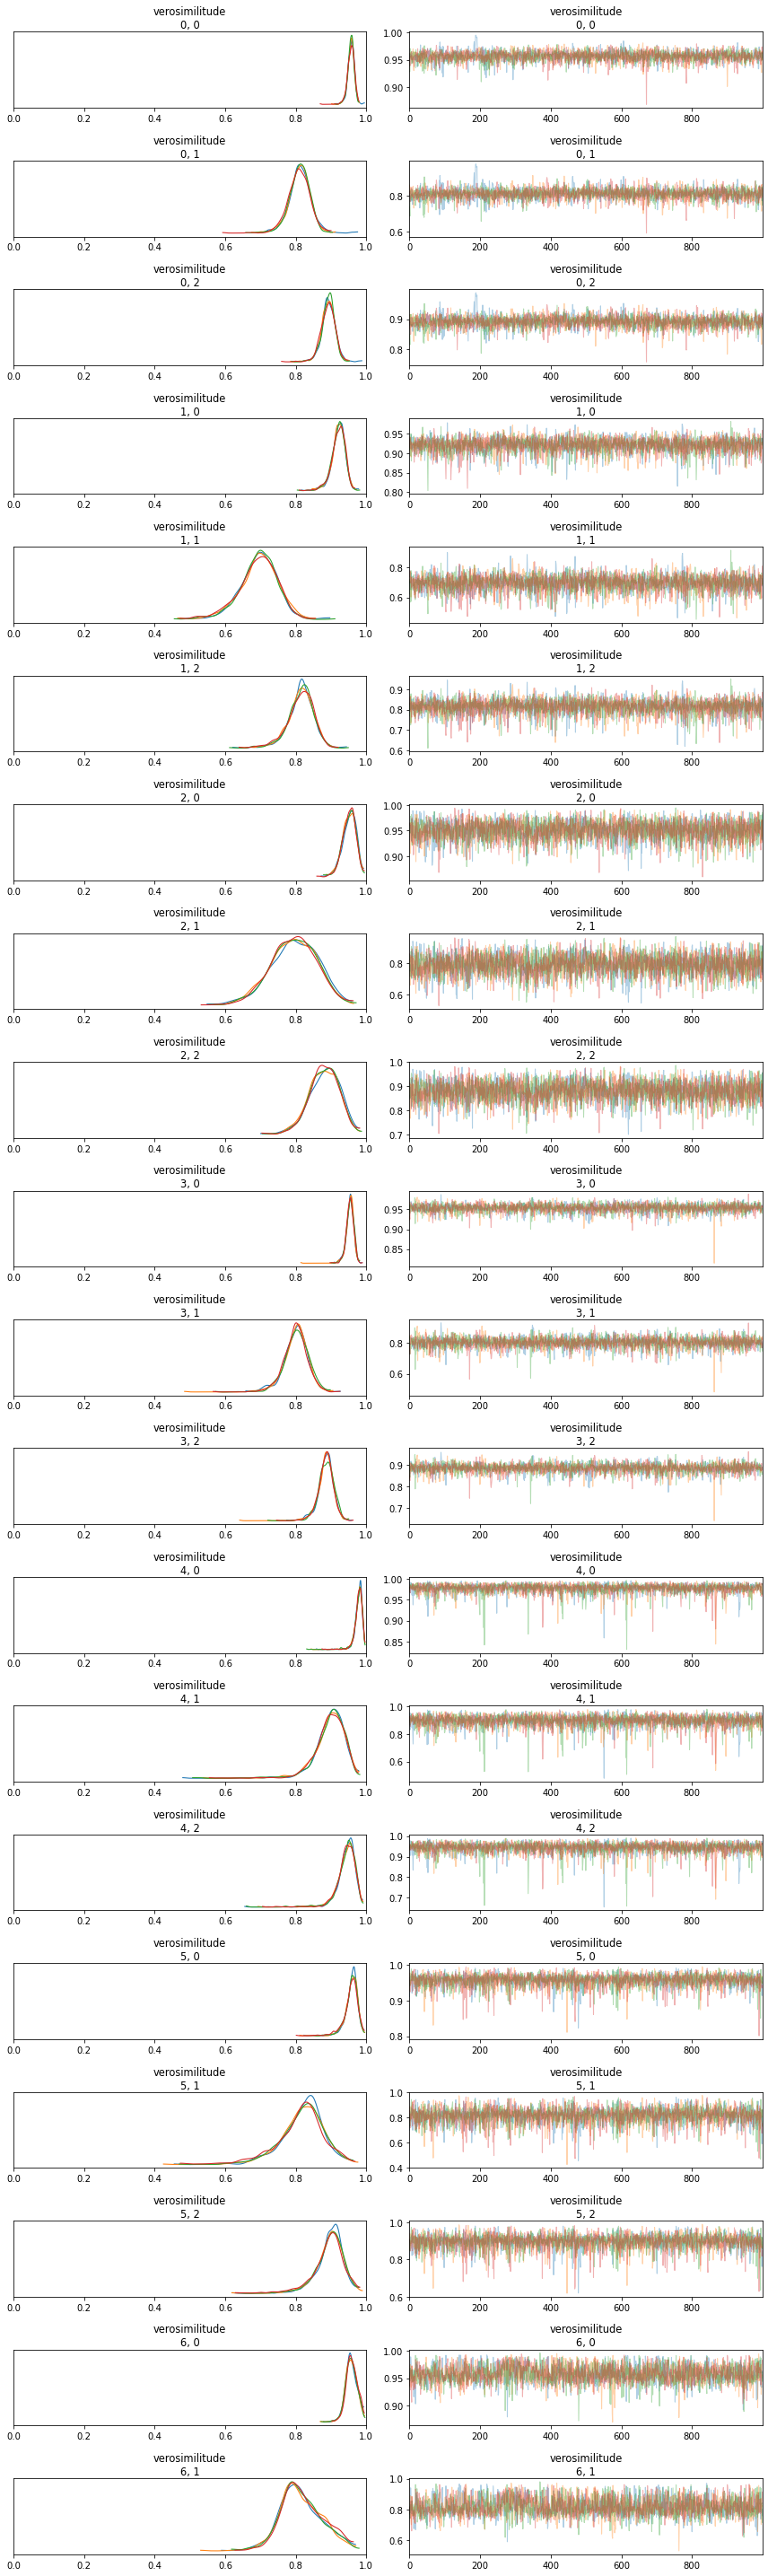

In [66]:
axes = az.plot_trace(
    trace, 
    var_names='verosimilitude', 
    compact=False,
)

[ax.set_xlim(0,1) for ax in axes[:,0]]

plt.tight_layout()
plt.show()

## Posterior predictive

In [67]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

Sampling: [chosen_utterances]


In [68]:
posterior_predictive_same_observed = (
    posterior_predictive
    .posterior_predictive
    .chosen_utterances
    .values == dt.utterance_index.values
)

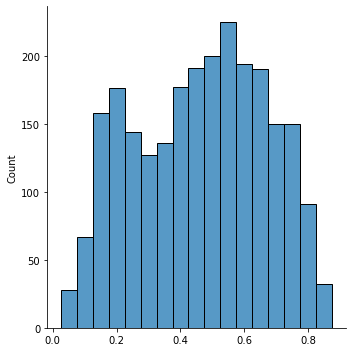

In [69]:
sns.displot(
    posterior_predictive_same_observed.mean((0,1)), 
)

In [70]:
dt.loc[:,'mean_posterior_right'] = posterior_predictive_same_observed.mean((0,1))

In [71]:
dt.groupby(['goal','true_state'])['mean_posterior_right'].mean()

goal         true_state
both         0             0.322546
             1             0.347074
             2             0.527170
             3             0.635951
informative  0             0.381738
             1             0.283078
             2             0.462259
             3             0.600711
social       0             0.393719
             1             0.439246
             2             0.496866
             3             0.666676
Name: mean_posterior_right, dtype: float64

In [72]:
pps = posterior_predictive.posterior_predictive.chosen_utterances.values.reshape(-1, 2436)

In [73]:
for i, subdt in dt.groupby('id'):
    print(i, end=' ')
    fig, axes = plt.subplots(
        3,
        4,
        sharex=True,
        sharey=True,
        figsize=(12,4)
    )
    
    for j, subsubdt in subdt.sort_values(['goal','true_state']).groupby('goal_id'):

        for datapoint, subsubsubdt in subsubdt.iterrows():
            state = subsubsubdt['true_state']

            unique, counts = np.unique(
                pps[:,datapoint], 
                return_counts=True
            )
            axes[j][state].bar(
                unique,
                normalize(counts,0)
            )
            axes[j][state].axvline(
                subsubsubdt['utterance_index'],
                color='red'
            )
        
    axes[0][0].set_xticks(np.arange(8))
    [
        ax.set_xticklabels(us, rotation=90) 
        for ax in axes[-1]
    ]
    [
        ax.set_ylabel(goal)
        for goal, ax in zip(goals,axes[:,0])
    ]
    
    plt.tight_layout()
    
    fig.savefig(
        f'participant_posteriorpred_mymodel/{i}.png',
        dpi=300
    )
    plt.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 

## Prior predictive

In [12]:
with model:
    prior_samples = pm.sample_prior_predictive()

Sampling: [S1_weight_condition, S1_weight_sigma, S1_weight_zs, S1_weights, chosen_utterances, pretend_temp, s1_rationality, values, verosim_condition, verosim_sigma, verosim_zs]


In [13]:
prior_samples

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data